# Fraud Detection

Fraudulent activity has permeated multiple sectors, from e-commerce and healthcare to banking and payment systems. This illicit industry amasses billions every year and is on an upward trajectory. The 2018 global economic crime survey by PwC verifies this assertion, revealing that 49 percent of the 7,200 enterprises surveyed had fallen prey to some form of fraudulent conduct.

<figure>
  <img src="images/artboard.png" alt="fraud-detection-banking" style="width:100%">
</figure>

Despite the perceived peril of fraud to businesses, the advent of sophisticated systems, such as rule engines or machine learning, equips us with the tools to detect and prevent such behaviors. In this notebook, we demonstrate how a machine learning system helps us achieve this.

At its core, a rules engine is a sophisticated software system that enforces one or more business rules in a real-time production environment. More often than not, these rules are the crystallization of hard-earned insights gleaned from domain experts. For instance, we could establish rules limiting the number of transactions in a given time frame, and blocking transactions that originate from previously identified fraudulent IPs and/or domains. Such rules prove highly effective in detecting certain types of fraud, yet they are not without their limitations. Rules with predefined threshold values may give rise to false positives or false negatives. To illustrate, imagine a rule that rejects any transaction exceeding \\$10,000 for a particular user. A seasoned fraudster might exploit this by staying one step ahead, consciously making a transaction slightly below this threshold (for instance, \\$9,999), thereby evading detection.

This is where machine learning comes to the rescue: By reducing both the risk of fraud and potential financial losses to businesses, machine learning fortifies the efficacy of the detection system. Combining this technology with rules-based systems ensures that fraud detection becomes a more precise and reliable endeavor. In our exploration, we will be inspecting fraudulent transactions using the Banksim dataset. This synthetically created dataset is an combination of various customer payments, made at different intervals and in varying amounts. Through this, we aim to provide a comprehensive understanding of how we can detect and curtail fraudulent activities with high accuracy.

In this notebook, you will go through the steps below:

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Oversampling with SMOTE](#Oversampling-with-SMOTE)
1. [K-Neighbours Classifier](#K-Neighbours-Classifier)
1. [Random Forest Classifier](#Random-Forest-Classifier)
1. [XGBoost Classifier](#XGBoost-Classifier)
1. [Logistic Regression Classifier](#Logistic-Regression-Classifier)
1. [Model Deployment](#Model-Deployment)
1. [Prediction](#Prediction)

Let's begin!

## Experiment Overview

First, let's go through the overview of this experiment. Below we can see the steps involved in this experiment:

- Import all required packages, define helper functions, and initialize global variables.
- Process and validate the data.
- Initiate the model training process and retrieve the best performing model.
- Deploy the model using KServe.
- Transform the Notebook in a Kubeflow pipeline using Kale

# Imports & Initialization

In this section, you import all the necessary packages that are required for our analysis. These packages provide the tools and functionalities needed to effectively process the data, train our machine learning model, and evaluate its performance.

In [1]:
import os
import json
import base64
import pickle
import requests
import urllib3
import subprocess

import joblib
import boto3
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from kubernetes import client
import mlflow

# Suppress warnings
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Set seaborn style
sns.set()

In [2]:
for key, value in os.environ.items():
    print(f'{key}: {value}')

PATH: /command:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
LANG: en_US.UTF-8
LC_ALL: en_US.UTF-8
HOSTNAME: eric-jupyter-data-science-0
KUBERNETES_SERVICE_PORT_HTTPS: 443
KUBERNETES_SERVICE_PORT: 443
KUBERNETES_SERVICE_HOST: 10.96.0.1
KUBERNETES_PORT: tcp://10.96.0.1:443
KUBERNETES_PORT_443_TCP: tcp://10.96.0.1:443
KUBERNETES_PORT_443_TCP_PROTO: tcp
KUBERNETES_PORT_443_TCP_ADDR: 10.96.0.1
KUBERNETES_PORT_443_TCP_PORT: 443
MLFLOW_S3_ENDPOINT_URL: http://local-s3-service.ezdata-system.svc.cluster.local:30000
MLFLOW_S3_IGNORE_TLS: true
PYTHON_REQUIREMENTS: /opt/venv_utils/requirements.txt
JUPYTERHUB_API_TOKEN: 3341447b98834b0ea38c6db102cdb066
JPY_API_TOKEN: 3341447b98834b0ea38c6db102cdb066
JUPYTERHUB_CLIENT_ID: jupyterhub-user-eric
JUPYTERHUB_HOST: 
JUPYTERHUB_OAUTH_CALLBACK_URL: /notebook/eric/eric-jupyter-data-science/user/eric/oauth_callback
JUPYTERHUB_OAUTH_SCOPES: ["access:servers!server=eric/", "access:servers!user=eric"]
JUPYTERHUB_OAUTH_ACCESS_SCOPES

In [3]:
import requests
import os
EZAF_ENV = "ezua13"
token_url = f"https://keycloak.{EZAF_ENV}.com/realms/UA/protocol/openid-connect/token"

data = {
    "username" : 'eric',
    "password" : 'Hpepoc@123',
    "grant_type" : "password",
    "client_id" : "ua-grant",
}

token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

token = token_responce.json()["access_token"]

In [5]:

os.environ["AWS_ENDPOINT_URL"] = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.environ["AWS_ENDPOINT_URL"]
os.environ['MLFLOW_TRACKING_TOKEN'] = token
os.environ["MLFLOW_TRACKING_URI"] = f"https://mlflow.{EZAF_ENV}.com"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
os.environ["MLFLOW_S3_IGNORE_TLS"] = "true"
os.environ["AWS_ACCESS_KEY_ID"] = token
os.environ["AWS_SECRET_ACCESS_KEY"] = "s3"
os.environ["AUTH_TOKEN"] = token

config = {
    
    "AWS_ENDPOINT_URL": 'http://local-s3-service.ezdata-system.svc.cluster.local:30000',
    "MLFLOW_S3_ENDPOINT_URL": os.environ["AWS_ENDPOINT_URL"],
    'MLFLOW_TRACKING_TOKEN': token,
    "MLFLOW_TRACKING_URI": f"https://mlflow.{EZAF_ENV}.com",
    "MLFLOW_TRACKING_INSECURE_TLS": "true",
    "MLFLOW_S3_IGNORE_TLS": "true",
    "AWS_ACCESS_KEY_ID": token,
    "AWS_SECRET_ACCESS_KEY": "s3",
    "AUTH_TOKEN": token,
    "KSERVE_MODEL_NAME": "fraud-detection",
    "NAMESPACE": open("/var/run/secrets/kubernetes.io/serviceaccount/namespace", "r").read(),
    "BUCKET": "experiments",
    "SOURCE_PATH": "demo-data/feed.csv",
    "SERVICE_ACCOUNT": "kserve-minio-sa",
    "PROTOCOL_VERSION": "v2",
    "EXPERIMENT_NAME" : 'fraud-detection-exp',
}

In [6]:
config

{'AWS_ENDPOINT_URL': 'http://local-s3-service.ezdata-system.svc.cluster.local:30000',
 'MLFLOW_S3_ENDPOINT_URL': 'http://local-s3-service.ezdata-system.svc.cluster.local:30000',
 'MLFLOW_TRACKING_TOKEN': 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICI3SndmdXcybFFtT2JpTTUybmZSdTVWYmdKVUo3SkRsUm40Njh4SUtiTGtnIn0.eyJleHAiOjE3MDk0NTYwOTIsImlhdCI6MTcwOTQ1MjQ5MiwianRpIjoiOTVkMTZlODAtNzgxOC00Y2RhLWI3MTMtM2Y5ZmI1NDZhNGMzIiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5lenVhMTMuY29tL3JlYWxtcy9VQSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJmNThjNGVlNi0zODQ0LTQzNzMtYTJiZC0xZTg1MDYzYTU5NzQiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJ1YS1ncmFudCIsInNlc3Npb25fc3RhdGUiOiIyZGI5NDBiOS0xMDlmLTQ4YmMtYTViMS1iMmI0YmM4MTY3ZDQiLCJhY3IiOiIxIiwiYWxsb3dlZC1vcmlnaW5zIjpbIi8qIl0sInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJ1YS1lbmFibGVkIiwib2ZmbGluZV9hY2Nlc3MiLCJhZG1pbiIsInVtYV9hdXRob3JpemF0aW9uIiwiZGVmYXVsdC1yb2xlcy11YSJdfSwic2NvcGUiOiJwcm9maWxlIGVtYWlsIiwic2lkIjoiMmRiOTQwYjktMTA5Zi00OGJjLWE1YjEtYjJiNGJjODE2N2Q0IiwidWlkIjoiNjAwNSIsInJlc291cmNlX2FjY2VzcyI

# Define Helper Functions

In this section, you define the function for plotting the Receiver Operating Characteristic Area Under the Curve (ROC_AUC). The ROC curve is a powerful diagnostic tool used for assessing the performance of binary classification models. It is a plot with the True Positive Rate (TPR) or sensitivity on the $y$-axis, and the False Positive Rate (FPR) or 1-specificity on the $x$-axis. Both rates range between `0` and `1`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

The Area Under the ROC Curve (AUC-ROC) is a single scalar value that aggregates the performance of the classifier over all possible thresholds, providing a measure of the model's ability to distinguish between positive and negative classes. Here's a breakdown of what the AUC-ROC value means:

- An AUC of `1.0` indicates that the classifier is perfect - it has a 100% true positive rate and a 0% false positive rate.
- An AUC of `0.5` suggests that the classifier is no better than random guessing - it has an equal chance of classifying a positive sample as negative, and vice versa.
- An AUC of less than `0.5` implies that the classifier is worse than random guessing - it's as if the model is "learning" to make the wrong predictions.

By visualizing the ROC curve, you can better understand the trade-off between sensitivity (the ability to correctly classify true positives) and specificity (the ability to correctly classify true negatives). This helps in selecting the optimal threshold that balances both metrics according to the specific needs of a given application.

In [7]:
def plot_roc_auc(y_test, preds):
    """Plot the Receiver Operating Characteristic (ROC) curve."""
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Exploratory Data Analysis

In this section, you undertake a detailed Exploratory Data Analysis (EDA) of the dataset, aiming to uncover critical insights that could inform your subsequent analysis. The initial snapshot of the dataset, as seen below, reveals nine feature columns and a target column. The feature columns are as follows:

<table style="width:70%">
  <tr>
    <th style="text-align:left">Feature</th>
    <th style="text-align:left">Description</th>
  </tr>
  <tr>
    <td style="text-align:left">Step</td>
    <td style="text-align:left">Represents the simulation day. The simulation ran for a total of 180 steps, equivalent to six months.</td>
  </tr>
  <tr>
    <td style="text-align:left">Customer</td>
    <td style="text-align:left">Denotes the unique ID assigned to each customer.</td>
  </tr>
  <tr>
    <td style="text-align:left">zipCodeOrigin</td>
    <td style="text-align:left">Represents the originating or source zip code.</td>
  </tr>
  <tr>
    <td style="text-align:left">Merchant</td>
    <td style="text-align:left">Specifies the unique ID of the merchant.</td>
  </tr>
  <tr>
    <td style="text-align:left">zipMerchant</td>
    <td style="text-align:left">Represents the zip code associated with the merchant.</td>
  </tr>
  <tr>
    <td style="text-align:left">Age</td>
    <td style="text-align:left">
        Classifies the age of customers:
        <ul>
            <li>0: <= 18 years</li>
            <li>1: 19-25 years</li>
            <li>2: 26-35 years</li>
            <li>3: 36-45 years</li>
            <li>4: 46-55 years</li>
            <li>5: 56-65 years</li>
            <li>6: > 65 years</li>
            <li>U: Unknown</li>
        </ul>
    </td>
  </tr>
  <tr>
    <td style="text-align:left">Gender</td>
    <td style="text-align:left">
        Indicates the gender of the customer:
        <ul>
            <li>E : Enterprise</li>
            <li>F: Female</li>
            <li>M: Male</li>
            <li>U: Unknown</li>
        </ul>
    </td>
  </tr>
  <tr>
    <td style="text-align:left">Category</td>
    <td style="text-align:left">Denotes the category of the purchase.</td>
  </tr>
  <tr>
    <td style="text-align:left">Amount</td>
    <td style="text-align:left">Specifies the purchase amount.</td>
  </tr>
  <tr>
    <td style="text-align:left">Fraud</td>
    <td style="text-align:left">The target variable, indicates whether the transaction was fraudulent (1) or benign (0).</td>
  </tr>
</table>

So, let's fetch the dataset from object storage and read it in a Pandas dataframe.

In [8]:
file_name = config.get("SOURCE_PATH")

client = boto3.client(
        service_name="s3",
        aws_access_key_id='Z4Q2KF6KXQJ3H34EI4Z239OA8GCZ9A8YY1LM42M99GWJWP04JZRZCGT3LQCDMAEBNOEJHQAKHRLP5PWBRNL3RK5BVW4XD8CNSEDSMFHIL8U',
        aws_secret_access_key='NN0SCZYJKJJSW8B6SW569J2LSMYOOH2X0KD9HRUFJ28M4AMYS6DQTTOT5YZ2R3TIBSGC9D293I1MGEF0W13W5TE2',
        endpoint_url='https://3.0.56.74:9000',
        verify=False)

client.download_file(Bucket="ua-bucket", Key=config.get("SOURCE_PATH"), Filename="feed.csv")

data = pd.read_csv("feed.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


Next, let's take a closer look at the types of data stored in each column and assess whether there are any missing values present in our dataset. Fortunately, this dataset does not contain any missing values, which means you don't have to include any imputation strategies in your preprocessing steps. The absence of missing values simplifies the data cleaning process and allows you to proceed with the analysis.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  int64  
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  int64  
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 45.4+ MB


## Synthetic Minority Over-sampling TEchnique (SMOTE)

Fraudulent data, as you can also observe from the plot below, tends to be imbalanced. This imbalance can lead to a bias towards the majority class during the training of a machine learning model. To counteract this issue, you can utilize techniques such as oversampling or undersampling.

- Oversampling refers to the process of augmenting the number of instances in the minority class by generating similar instances.
- Undersampling involves reducing the number of instances in the majority class by randomly selecting data points until the count aligns with the minority class.

Each of these strategies has associated risks. For instance, oversampling may result in the creation of duplicate or highly similar data points, which may not be beneficial for fraud detection given that fraudulent transactions often exhibit unique characteristics. Undersampling, however, implies a loss of data points, and consequently, valuable information.

To balance the dataset without introducing excessive redundancy or losing crucial information, you could employ an oversampling technique known as SMOTE (Synthetic Minority Over-sampling TEchnique). Unlike naive oversampling methods, SMOTE generates synthetic instances of the minority class using neighboring instances, ensuring that the new samples are not exact copies but closely resemble existing instances. This technique can potentially improve the performance of your model by providing it with a more representative and balanced view of the different classes in our dataset.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


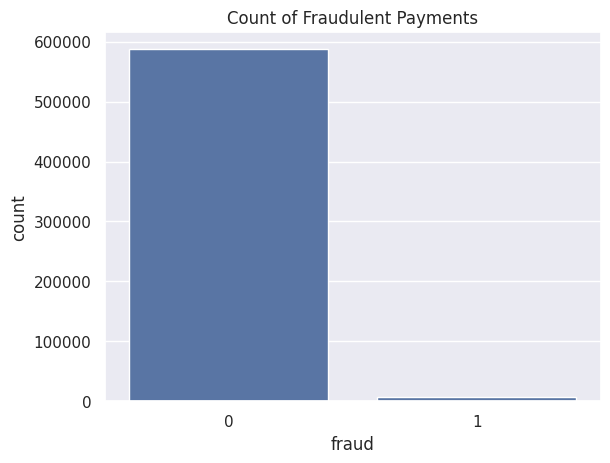

Number of normal examples: 587443
Number of fradulent examples: 7200


In [10]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()

print("Number of normal examples:", df_non_fraud.fraud.count())
print("Number of fradulent examples:", df_fraud.fraud.count())

Moreover, by examining the data below, it becomes apparent that the 'leisure' and 'travel' categories seem to be most frequently targeted by fraudsters. It appears that these perpetrators might be strategically choosing categories where people typically spend more on average.

To validate this hypothesis, you need to delve deeper into the transaction data, specifically comparing the amounts transacted in fraudulent and non-fraudulent cases. By doing this, you could gain a better understanding of the patterns and behaviors of fraudsters, and thus improve the effectiveness of our detection system.

In [11]:
print("Mean feature values per category:")
data.groupby('category')[['amount', 'fraud']].mean()

Mean feature values per category:


,amount,fraud
category,,
es_barsandrestaurants,43.461014,0.018829
es_contents,44.547571,0.000000
es_fashion,65.666642,0.017973
es_food,37.070405,0.000000
es_health,135.621367,0.105126
es_home,165.670846,0.152064
es_hotelservices,205.614249,0.314220
es_hyper,45.970421,0.045917
es_leisure,288.911303,0.949900


Upon further analysis, the initial hypothesis—that fraudsters predominantly target categories where average spending is higher—holds true only to a certain extent. However, a clear trend emerges when you examine the transaction values associated with fraudulent activities.

As illustrated in the table below, you can confidently assert that a fraudulent transaction is typically significantly larger—about four times or more—than the average transaction within a given category. This significant deviation in transaction amounts may provide a useful indicator when identifying potential fraudulent activities in the future.

In [12]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),
           df_non_fraud.groupby('category')['amount'].mean(),
           data.groupby('category')['fraud'].mean()*100],
           keys=["Fraudulent","Non-Fraudulent","Percent(%)"], axis=1,sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
es_transportation,NaN,26.958187,0.000000
es_food,NaN,37.070405,0.000000
es_hyper,169.255429,40.037145,4.591669
es_barsandrestaurants,164.092667,41.145997,1.882944
es_contents,NaN,44.547571,0.000000
es_wellnessandbeauty,229.422535,57.320219,4.759380
es_fashion,247.008190,62.347674,1.797335
es_leisure,300.286878,73.230400,94.989980
es_otherservices,316.469605,75.685497,25.000000


Upon examining the average amount spent across various categories, you can see that spending is typically similar, generally ranging from `0` to `500`, once you exclude the outliers. However, the 'travel' category stands as an exception, with spending reaching significantly higher levels.

This deviation in the 'travel' category could be due to a variety of factors, such as the inherent high cost associated with travel and tourism activities. Such information is crucial, not only for understanding the spending behavior of customers but also for improving our fraud detection strategies, as categories with higher average spending might attract more fraudulent activities.

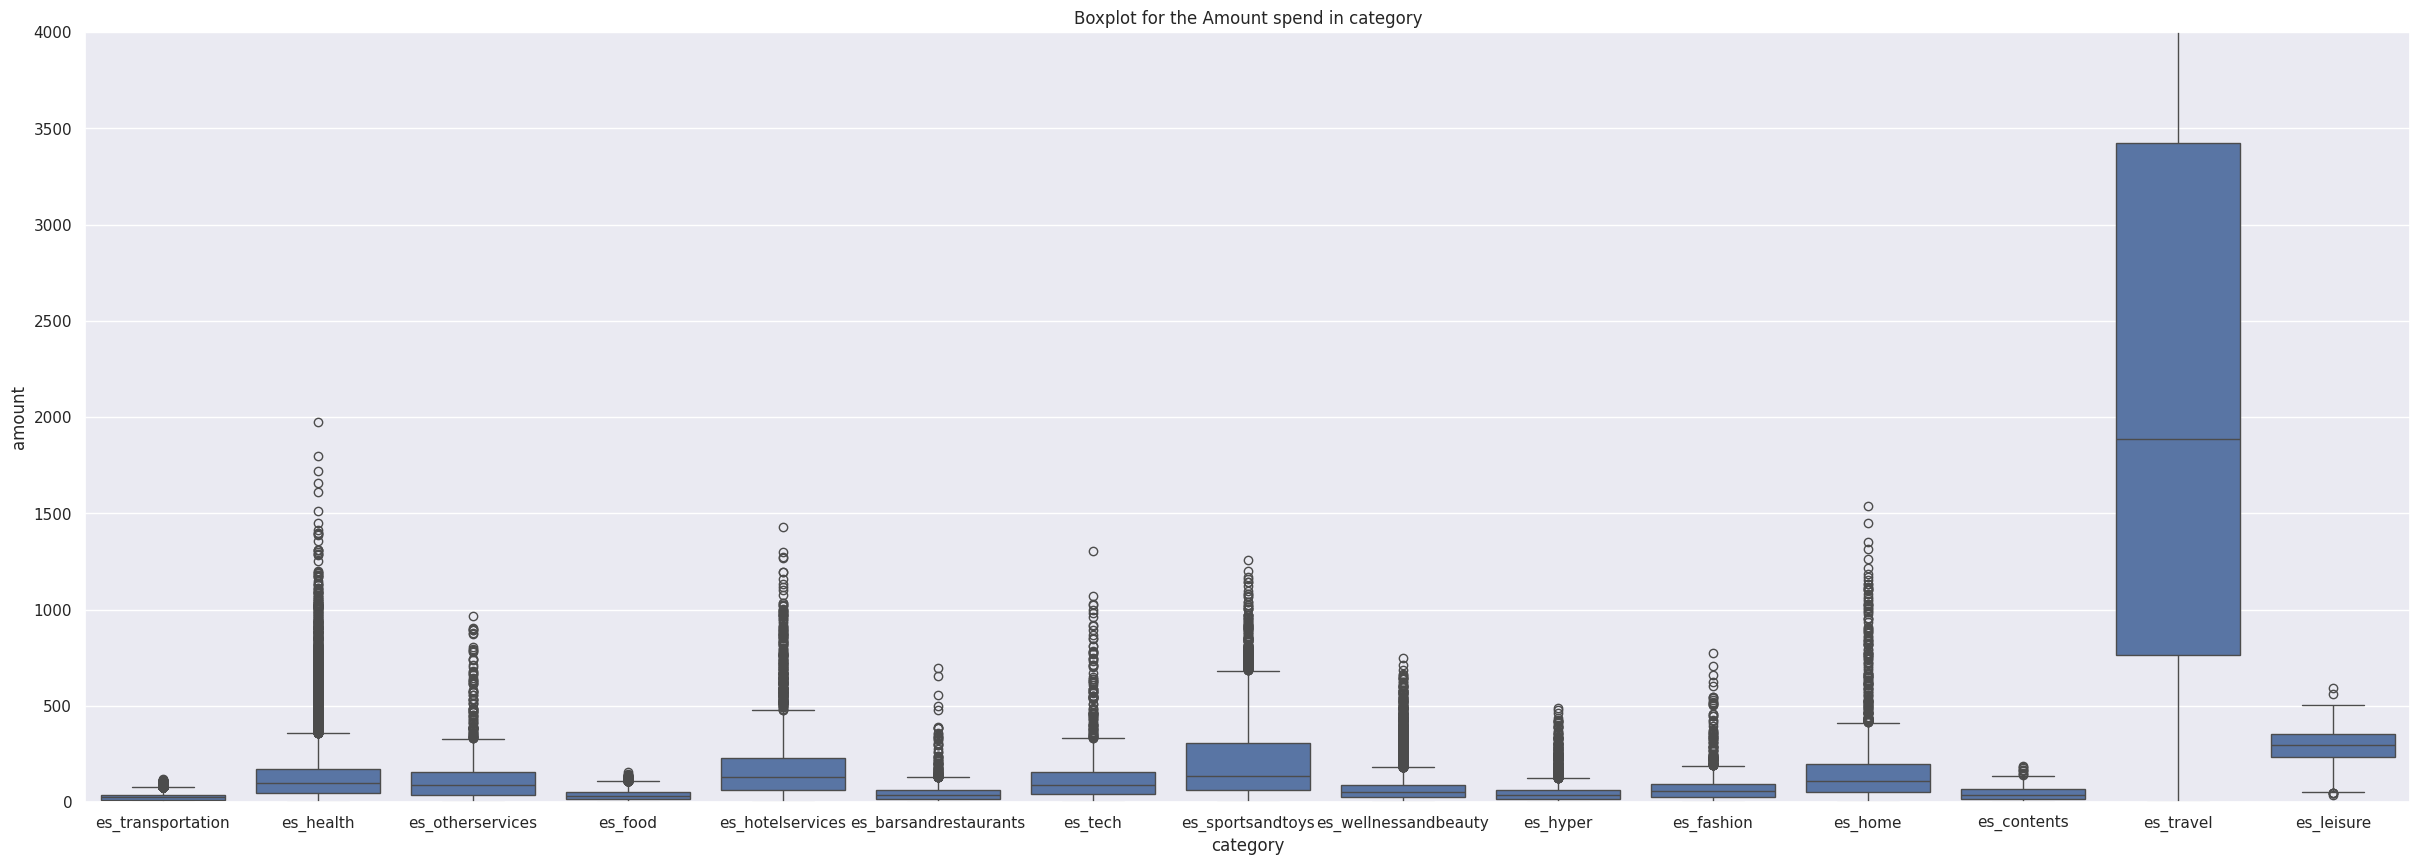

In [13]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30, 10))
sns.boxplot(x=data.category, y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0, 4000)
plt.show()

Reinforcing previous observations, the histogram below presents a striking representation of the relationship between the number and amount of fraudulent transactions. While the count of fraudulent transactions is relatively low, the monetary value they represent is disproportionately high. This pattern underscores the serious financial implications of fraud, even when the number of incidents might appear relatively minor at first glance. It's precisely this disparity that makes effective and precise fraud detection systems crucial for the integrity of any financial system.

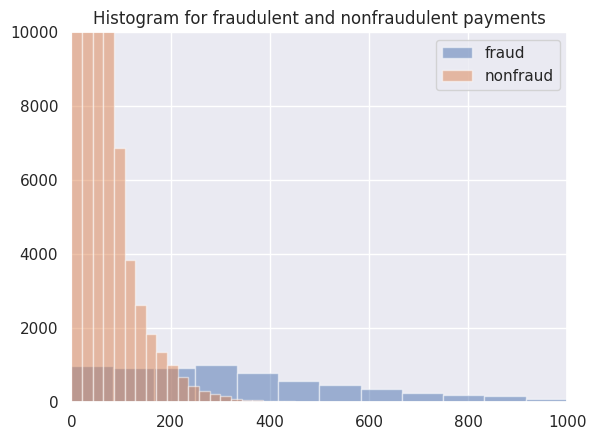

In [14]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0, 10000)
plt.xlim(0, 1000)
plt.legend()
plt.show()

Examining the table below, you can observe the percentage of fraudulent transactions within each age category. Among known age categories, the group '0' (representing ages 18 and under) exhibits the highest fraud percent, standing at `1.957586`. This data is crucial for enhancing our understanding of the demographics most vulnerable to fraudulent activities and can be instrumental in tailoring our fraud detection algorithms and preventive measures accordingly.

In [15]:
((data.groupby('age')['fraud'].mean() * 100).reset_index()
                                            .rename(columns={'age':'Age','fraud' : 'Fraud Percent'})
                                            .sort_values(by='Fraud Percent'))

,Age,Fraud Percent
7,U,0.594228
6,6,0.974826
5,5,1.095112
1,1,1.185254
3,3,1.192815
2,2,1.251401
4,4,1.293281
0,0,1.957586


# **Data Preprocessing**

In this section, you will focus on preprocessing the data and preparing it for the training phase. Upon investigating our data, you can see that there are two columns with only one unique zip code value. In terms of machine learning, a feature with a single value adds no predictive power, since it remains constant for all observations. Therefore, you could drop this column from the dataset to streamline the model training process.

In [16]:
print("Unique 'zipCodeOri' values:", data.zipcodeOri.nunique())
print("Unique 'zipMerchant' values:", data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(["zipcodeOri", "zipMerchant"], axis=1)

Unique 'zipCodeOri' values: 1
Unique 'zipMerchant' values: 1


Next, you will convert the categorical features into numerical values. One efficient way to transform categorical values into numerical representations is by utilizing the pandas library's `cat.codes` property. This method allows us to encode categorical variables into numerical codes without significantly increasing the dimensionality of our dataset.

In [17]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


To proceed with our model training, you need to define our independent variable ($X$) and dependent/target variable ($y$). In this context, the independent variable ($X$) refers to the set of features or attributes that you will use to predict the dependent/target variable ($y$). By properly defining $X$ and $y$, you can establish the foundation for training your machine learning model and exploring the relationships between the independent variables and the dependent/target variable.

In [18]:
X = data_reduced.drop(['fraud'], axis=1)
y = data['fraud']

print(X.head(), "\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


# Oversampling with SMOTE

To address the issue of class imbalance in the dataset, you will apply the Synthetic Minority Over-sampling TEchnique (SMOTE). As you saw earlier, this oversampling technique generates synthetic instances of the minority class (fraudulent transactions) by interpolating between existing instances. By applying SMOTE, you will effectively increase the number of instances in the minority class to match the number of instances in the majority class (non-fraudulent transactions). As a result, you will have an equal number of instances for both classes, which helps to alleviate the potential bias and improve the performance of your machine learning model.

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

print(y_res.value_counts())

fraud
0        587443
1        587443
dtype: int64


# Train-Test Split for Model Performance Measurement

To assess the performance of your machine learning model, you should split the data into two sets: a training set and a testing set. The training set will be used to train the model, allowing it to learn patterns and relationships within the data. The testing set, on the other hand, will be used to evaluate the model's performance on unseen data. By measuring the model's performance on the testing set, you can gain insights into how well it generalizes to new and unseen instances.

While cross-validation is a commonly recommended practice for model evaluation, in this case, due to the large number of instances in the dataset, you could opt for a simple train-test split. However, it is important to note that cross-validation should be used whenever feasible, as it provides a more comprehensive evaluation of the model's performance and helps to mitigate potential biases introduced by a single train-test split.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y_res)

As mentioned earlier, fraud datasets often suffer from severe class imbalance, where the majority of instances are non-fraudulent transactions. If you were to naively predict non-fraudulent for all instances in such imbalanced datasets, we would achieve a high accuracy score, typically around 99%. However, this misleading accuracy score does not indicate a successful fraud detection system. In reality, the goal of a fraud detection classifier is to identify the fraudulent transactions accurately, which are the minority class in the dataset.

To accurately evaluate the performance of a fraud detection classifier, it is essential to consider metrics that are sensitive to both the minority (fraudulent) and majority (non-fraudulent) classes. Metrics such as precision, recall, F1-score, and the area under the Receiver Operating Characteristic (ROC) curve provide a more comprehensive assessment of the model's effectiveness in detecting fraud.

In addition, it is important to establish a baseline accuracy score that exceeds the accuracy achieved by simply predicting the majority class (non-fraudulent). This baseline accuracy serves as a benchmark for evaluating the performance of the fraud detection model, ensuring that it performs significantly better than a simplistic approach and demonstrates its ability to accurately detect fraudulent transactions.

Therefore, when evaluating the performance of a fraud detection model, it is imperative to consider multiple metrics that provide a comprehensive understanding of its effectiveness in detecting both fraudulent and non-fraudulent instances, rather than relying solely on accuracy.

In [21]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count() / np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


!pip3 install --proxy http://hpeproxy.its.hpecorp.net:443/ 'whylogs[viz]'# K-Neighbours Classifier

The K-Nearest Neighbors (KNN) classifier is a popular machine learning algorithm used for classification. In this section, you will train a KNN classifier as a potential approach for the fraud detection problem.

The KNN classifier works based on the principle that instances with similar feature values tend to belong to the same class. It classifies new instances by finding the K nearest neighbors in the training set and assigning the majority class label among those neighbors to the new instance.

Key features of the KNN classifier include:

- K value: The value of K represents the number of neighbors to consider for classification. It is an important parameter that needs to be carefully chosen to achieve optimal performance.
- Distance metric: The choice of distance metric, such as Euclidean distance or Manhattan distance, determines the similarity between instances and influences the classification process.
- Computational cost: The KNN classifier can be computationally expensive, especially for large datasets, as it requires calculating distances between the new instance and all training instances. Therefore, it is essential to consider the computational trade-offs when working with KNN.

By employing the KNN classifier, we can leverage the proximity-based nature of the algorithm to detect potential fraud patterns in our data. However, it is important to experiment with different values of K and evaluate the model's performance using appropriate evaluation metrics to ensure its effectiveness in detecting fraudulent transactions.

2024/03/03 07:58:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Found credentials in environment variables.
2024/03/03 08:00:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/c

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


2024/03/03 08:01:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


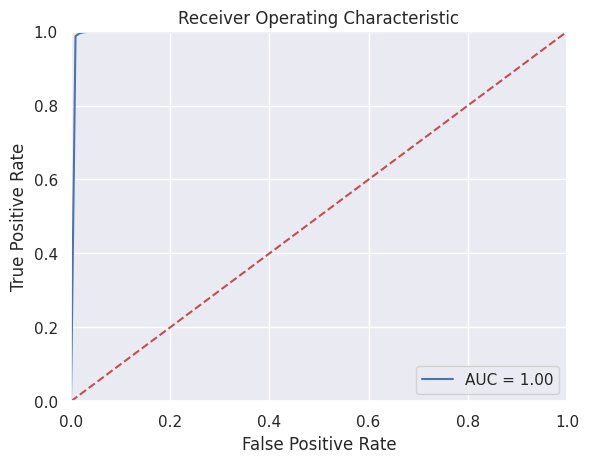

Accuracy: 98.70%


In [22]:
os.environ["AWS_ENDPOINT_URL"] = config.get('AWS_ENDPOINT_URL')
os.environ["MLFLOW_S3_ENDPOINT_URL"] = config.get("AWS_ENDPOINT_URL")
os.environ['MLFLOW_TRACKING_TOKEN'] = config.get("MLFLOW_TRACKING_TOKEN")
os.environ["MLFLOW_TRACKING_URI"] = config.get("MLFLOW_TRACKING_URI")
os.environ["MLFLOW_S3_IGNORE_TLS"] = config.get("MLFLOW_S3_IGNORE_TLS")
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = config.get("MLFLOW_TRACKING_INSECURE_TLS")
os.environ["AWS_ACCESS_KEY_ID"] = config.get('MLFLOW_TRACKING_TOKEN')
os.environ["AWS_SECRET_ACCESS_KEY"] = config.get('AWS_SECRET_ACCESS_KEY')
os.environ["AUTH_TOKEN"] = config.get('AUTH_TOKEN')

mlflow.set_tracking_uri(config.get("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(config.get("EXPERIMENT_NAME"))

with mlflow.start_run() as run:
    mlflow.sklearn.autolog()

    knn = KNeighborsClassifier(n_neighbors=5, p=1)
    knn.fit(X_train, np.ravel(y_train, order='C'))
    y_pred = knn.predict(X_test)

    print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test, y_pred))
    plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    run_id = run.info.run_id

    mlflow.end_run()

# Random Forest Classifier

The Random Forest classifier is a powerful and versatile machine learning algorithm widely used for classification. In the context of our fraud detection problem, let's explore the Random Forest classifier as a potential approach.

The Random Forest algorithm is an ensemble method that works by constructing a multitude of decision trees and aggregating their predictions to make the final classification. Each decision tree in the Random Forest is trained on a different subset of the data, using a random selection of features. This randomness helps to reduce overfitting and improve the generalization ability of the model.

Key features of the Random Forest classifier include:

- Ensemble learning: The Random Forest classifier combines the predictions of multiple decision trees to make a more robust and accurate prediction. The ensemble approach helps to mitigate the risk of individual decision trees making errors.
- Feature importance: The Random Forest classifier provides a measure of feature importance, indicating the relative importance of each feature in making predictions. This information can be valuable for understanding the key factors contributing to fraudulent transactions.
- Parallelization: The Random Forest algorithm lends itself well to parallelization, as each decision tree in the forest can be trained independently. This makes it suitable for large datasets and can lead to faster training times.

When applying the Random Forest classifier to our fraud detection problem, it is crucial to tune hyperparameters, such as the number of decision trees in the forest and the maximum depth of each tree, to optimize performance. Additionally, evaluating the model's performance using appropriate metrics and considering feature importance can provide valuable insights for fraud detection and prevention.

In [ ]:
os.environ["AWS_ENDPOINT_URL"] = config.get('AWS_ENDPOINT_URL')
os.environ["MLFLOW_S3_ENDPOINT_URL"] = config.get("AWS_ENDPOINT_URL")
os.environ['MLFLOW_TRACKING_TOKEN'] = config.get("MLFLOW_TRACKING_TOKEN")
os.environ["MLFLOW_TRACKING_URI"] = config.get("MLFLOW_TRACKING_URI")
os.environ["MLFLOW_S3_IGNORE_TLS"] = config.get("MLFLOW_S3_IGNORE_TLS")
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = config.get("MLFLOW_TRACKING_INSECURE_TLS")
os.environ["AWS_ACCESS_KEY_ID"] = config.get('MLFLOW_TRACKING_TOKEN')
os.environ["AWS_SECRET_ACCESS_KEY"] = config.get('AWS_SECRET_ACCESS_KEY')
os.environ["AUTH_TOKEN"] = config.get('AUTH_TOKEN')

mlflow.set_tracking_uri(config.get("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(config.get("EXPERIMENT_NAME"))

with mlflow.start_run() as run:
    mlflow.sklearn.autolog()
    rf_clf = RandomForestClassifier(n_estimators=50,
                                max_depth=8,
                                random_state=42,
                                verbose=1,
                                class_weight="balanced")
    rf_clf.fit(X_train, y_train.values.ravel())
    y_pred = rf_clf.predict(X_test)

    print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test, y_pred))
    plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    run_id = run.info.run_id

    mlflow.end_run()

# XGBoost Classifier

The XGBoost (Extreme Gradient Boosting) classifier is a state-of-the-art machine learning algorithm known for its exceptional performance and widespread use in various domains, including fraud detection. Let's delve into the XGBoost classifier and its relevance to our fraud detection problem.

XGBoost is an ensemble learning method that combines the power of gradient boosting with several innovative techniques. It excels at handling large-scale datasets and effectively capturing complex relationships between features. The algorithm constructs a series of decision trees iteratively, where each subsequent tree corrects the mistakes made by the previous trees.

Key features of the XGBoost classifier include:

- Gradient boosting: XGBoost utilizes gradient boosting, a technique that sequentially adds decision trees to improve the model's predictive accuracy. By iteratively minimizing a specified loss function, XGBoost focuses on capturing intricate patterns and relationships in the data.
- Feature importance: XGBoost provides valuable insights into feature importance by quantifying the impact of each feature on the model's performance. This information aids in identifying the most influential features for detecting fraudulent transactions.
- Parallel processing: XGBoost supports parallel processing, enabling faster training times and efficient computation on large-scale datasets. It leverages the capabilities of multicore processors and distributed computing frameworks for accelerated model training.

When employing the XGBoost classifier for fraud detection, it is crucial to tune hyperparameters, such as the learning rate, maximum depth of trees, and regularization parameters, to optimize performance. Evaluating the model's performance using appropriate metrics and considering feature importance can enhance the effectiveness of our fraud detection system.

In [ ]:
os.environ["AWS_ENDPOINT_URL"] = config.get('AWS_ENDPOINT_URL')
os.environ["MLFLOW_S3_ENDPOINT_URL"] = config.get("AWS_ENDPOINT_URL")
os.environ['MLFLOW_TRACKING_TOKEN'] = config.get("MLFLOW_TRACKING_TOKEN")
os.environ["MLFLOW_TRACKING_URI"] = config.get("MLFLOW_TRACKING_URI")
os.environ["MLFLOW_S3_IGNORE_TLS"] = config.get("MLFLOW_S3_IGNORE_TLS")
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = config.get("MLFLOW_TRACKING_INSECURE_TLS")
os.environ["AWS_ACCESS_KEY_ID"] = config.get('MLFLOW_TRACKING_TOKEN')
os.environ["AWS_SECRET_ACCESS_KEY"] = config.get('AWS_SECRET_ACCESS_KEY')
os.environ["AUTH_TOKEN"] = config.get('AUTH_TOKEN')

mlflow.set_tracking_uri(config.get("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(config.get("EXPERIMENT_NAME"))


with mlflow.start_run() as run:
    mlflow.sklearn.autolog()
    XGBoost_CLF = xgb.XGBClassifier(silent=None, seed=42, colsample_bynode=1, max_depth=6, learning_rate=0.05, n_estimators=50, 
                                    objective="binary:hinge", booster='gbtree', missing=1,
                                    n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                    subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                    base_score=0.5, random_state=42, verbosity=1)
    XGBoost_CLF.fit(X_train, y_train)
    y_pred = XGBoost_CLF.predict(X_test)

    print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix of: \n", confusion_matrix(y_test, y_pred))
    plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    run_id = run.info.run_id

    mlflow.end_run()

# Logistic Regression Classifier

The Logistic Regression classifier is a well-established and widely used algorithm for binary classification tasks, making it relevant to our fraud detection problem. Let's explore the Logistic Regression classifier and its applicability to our scenario.

Despite its name, Logistic Regression is a classification algorithm that models the probability of an instance belonging to a particular class. It is particularly suited for problems where the dependent variable is binary, as in our case where we aim to distinguish between fraudulent and non-fraudulent transactions.

Key features of the Logistic Regression classifier include:

- Probabilistic modeling: Logistic Regression models the relationship between the independent variables and the probability of belonging to a specific class. It employs the logistic function (also known as the sigmoid function) to map the output to a probability score.
- Interpretability: Logistic Regression provides interpretable coefficients for each independent variable, which allows us to understand the impact of the features on the likelihood of fraud. These coefficients indicate the direction and magnitude of the relationship between each feature and the probability of fraudulent transactions.
- Efficiency: Logistic Regression is computationally efficient and can handle large datasets with relative ease. It converges quickly and is less prone to overfitting, making it suitable for situations where interpretability and simplicity are important factors.

When utilizing the Logistic Regression classifier for fraud detection, it is crucial to preprocess the data appropriately, handle categorical variables, and consider feature scaling if necessary. Evaluating the model's performance using appropriate metrics such as precision, recall, F1-score, and area under the ROC curve can provide a comprehensive understanding of its effectiveness in detecting fraudulent transactions.

In [ ]:
os.environ["AWS_ENDPOINT_URL"] = config.get('AWS_ENDPOINT_URL')
os.environ["MLFLOW_S3_ENDPOINT_URL"] = config.get("AWS_ENDPOINT_URL")
os.environ['MLFLOW_TRACKING_TOKEN'] = config.get("MLFLOW_TRACKING_TOKEN")
os.environ["MLFLOW_TRACKING_URI"] = config.get("MLFLOW_TRACKING_URI")
os.environ["MLFLOW_S3_IGNORE_TLS"] = config.get("MLFLOW_S3_IGNORE_TLS")
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = config.get("MLFLOW_TRACKING_INSECURE_TLS")
os.environ["AWS_ACCESS_KEY_ID"] = config.get('MLFLOW_TRACKING_TOKEN')
os.environ["AWS_SECRET_ACCESS_KEY"] = config.get('AWS_SECRET_ACCESS_KEY')
os.environ["AUTH_TOKEN"] = config.get('AUTH_TOKEN')

mlflow.set_tracking_uri(config.get("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(config.get("EXPERIMENT_NAME"))


with mlflow.start_run() as run:
    mlflow.sklearn.autolog()
    LRmodel = LogisticRegression(max_iter=999, solver='lbfgs')
    LRmodel.fit(X_train, y_train)

    # Get predictions
    y_pred = LRmodel.predict(X_test)
    print("Classification Report for LogisticRegression: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix of LogisticRegression: \n", confusion_matrix(y_test, y_pred))
    plot_roc_auc(y_test, LRmodel.predict_proba(X_test)[:,1])

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    run_id = run.info.run_id

    mlflow.end_run()

# Model Deployment

After training and evaluating our fraud detection model, the next step is to deploy it into a production environment where it can be used to detect fraud in real-time transactions.

Before diving into deployment, you should start by creating a secure environment for accessing the S3 endpoint. First, you define a Secret object, which securely holds the necessary credentials. Additionally, we create a ServiceAccount object, associating it with the secret to establish an identity for the deployment process.

In [ ]:
manifest = f"""
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "fraud-detection"
spec:
  predictor:
    serviceAccountName: kserve-local-s3-sa
    sklearn:
      protocolVersion: "v2"
      storageUri: "s3://mlflow/4/01eb7d363edd4dd49d1d40cd88845e3a/artifacts/model"
"""

os.makedirs("manifests", exist_ok=True)

with open(os.path.join("manifests", "isvc.yaml"), "w") as f:
    f.write(manifest)

In [ ]:
res = subprocess.run(["kubectl", "apply", "-f", "manifests/isvc.yaml"])

# Prediction

With the deployed fraud detection model, we can now utilize it to make predictions on new, incoming transactions. The prediction process involves passing the relevant transaction data through the deployed model to obtain a prediction of whether the transaction is fraudulent or not.

In [ ]:
data = pd.read_csv(os.path.join("dataset", "generated-data.csv"))
data.head(5)

In [ ]:
data_reduced = data.drop(['zipcodeOri', 'zipMerchant'], axis=1)
data_reduced.loc[:, ['customer', 'merchant', 'category']].astype('category')

col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')

data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

In [ ]:
DOMAIN_NAME = "svc.cluster.local"  # change this to your domain for external access
NAMESPACE = config.get("NAMESPACE")
DEPLOYMENT_NAME = config.get("KSERVE_MODEL_NAME")
MODEL_NAME = "model"
SVC = f'{DEPLOYMENT_NAME}-predictor.{NAMESPACE}.{DOMAIN_NAME}'
URL = f"https://{SVC}/v2/models/{MODEL_NAME}/infer"

print(URL)

In [ ]:
X = data_reduced.drop(['fraud'], axis=1)
y = data_reduced['fraud']
print("Shape:", [len(X.values), len(X.values[0])])

inference_request = {
    "inputs" : [{
        "name" : "fraud-detection-infer-001",
        "datatype": "FP32",

        "shape": [1, 7],
        # Example of non-fraudulent Transaction Dtls
        # "data": [list(item) for item in X.values][14],
        # Example of a fraudulent request
        "data": [list(item) for item in X.values][17],
    }]
}

print("data:", inference_request)

In [ ]:
%update_token

In [ ]:
session = requests.Session()
message = {"message":"", "value":""}

headers = {"Authorization": f"Bearer {os.environ['AUTH_TOKEN']}"}
response = requests.post(URL, json=inference_request, headers=headers, verify=False)

if response.status_code == 200:
    if json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0] != None and json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0] == 1:
        message['message'] = "Fraudulent Banking Transaction!"
        message['value'] = json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0]        
        print('\033[91m' "Prediction Result:", json.dumps(message))
    elif len(json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'])>1:
        print("Model-Infer-dtl:[data]:\n", json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'])
    else:
        message['message'] = "Non-fraudulent Banking Transaction!"
        message['value'] = json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0]   
        print('\033[92m'  "Prediction Result:", json.dumps(message))
else:
    print(response.status_code, response.content)

# Conclusion

In this notebook, the primary objective was to develop a fraud detection model using bank payment data. We employed various classifiers and achieved remarkable results in detecting fraudulent transactions. As fraud datasets often suffer from class imbalance, we utilized the SMOTE oversampling technique to address this issue by generating synthetic minority class examples.

# References

1. Lavion, Didier; et al, "PwC's Global Economic Crime and Fraud Survey 2022", 
2. https://www.pwc.com/gx/en/services/forensics/economic-crime-survey.html
3. https://www.pwc.com/gx/en/services/forensics/gecs/outcomes-of-platform-fraud.svg |
4. https://www.pwc.com/gx/en/forensics/gecsm-2022/pdf/PwC%E2%80%99s-Global-Economic-Crime-and-Fraud-Survey-2022.pdf
5. [SMOTE: Synthetic Minority Over-sampling Technique](https://jair.org/index.php/jair/article/view/10302)
6. [Banksim Data Set Paper](http://www.msc-les.org/proceedings/emss/2014/EMSS2014_144.pdf)